In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks


total time is 100.0


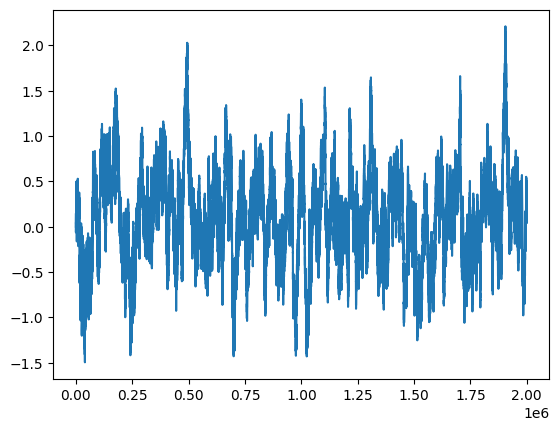

In [2]:
sampling_rate=2*1e4
sample_time=1/sampling_rate
N=2000000
def ou_noise(n, dt=1.0, mu=0.0, tau=20.0, sigma=1.0, x0=0.0, rng=None):
    rng = np.random.default_rng(rng)
    x = np.empty(n)
    x[0] = x0
    a = np.exp(-dt / tau)
    sd = sigma * np.sqrt(1 - a*a)
    for t in range(1, n):
        # if t%int(tau/dt)==0:
        #     sd=sd+1e-4
        x[t] = mu + a*(x[t-1] - mu) + sd * rng.normal()
    return x
#I am setting tau to be 50ms

#def correlated_noise_time_varying()
x = ou_noise(N, dt=sample_time, tau=0.5, sigma=0.5)
#print()
#plt.plot(np.fft.fft(x))
plt.plot(x)
#print(10*1e-3/sample_time)
print("total time is",sample_time*N)

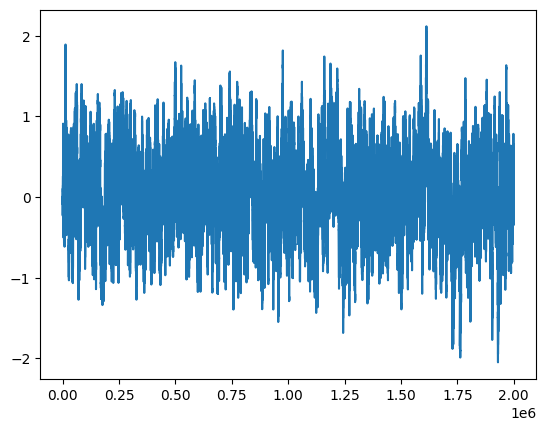

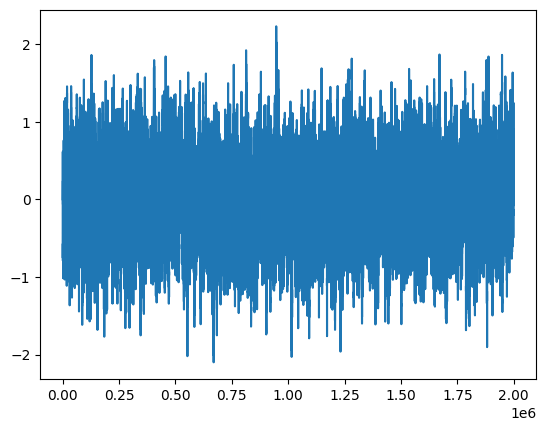

In [3]:
Channel_dict={}
num_channels=2
actual_coh_time={}
# for i in range(2):
#     tau_I=500*(i+1)
#     tau_Q=500*(i+1)
#     Channel_dict[i]={'I':ou_noise(N,dt=sample_time,tau=tau_I*1e-4,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=tau_Q*1e-4,sigma=0.5)}
#     actual_coh_time[i]={'I':tau_I*1e-4/sample_time,'Q':tau_Q*1e-4/sample_time}
# print(actual_coh_time)
rng = np.random.default_rng(12345)
Channel_dict[0]={'I':ou_noise(N,dt=sample_time,tau=0.1,sigma=0.5, rng = rng),'Q':ou_noise(N,dt=sample_time,tau=0.1,sigma=0.5, rng = rng)}
Channel_dict[1]={'I':ou_noise(N,dt=sample_time,tau=0.03,sigma=0.5, rng = rng),'Q':ou_noise(N,dt=sample_time,tau=0.03,sigma=0.5, rng = rng)}
plt.plot(Channel_dict[0]["I"])
plt.show()
plt.plot(Channel_dict[1]["I"])

In [156]:
initial_scan_duration = int(2 / sample_time)        # 2 seconds simulated pre-scan
NOP_duration = int(10 / sample_time)       # 4 seconds simulated NOP
DFS_threshold = 0.3                        # Probability of radar presence

In [157]:
from numpy.fft import rfft, irfft

# def autocorr_fft(x):
#     x = np.asarray(x)
#     x = x - x.mean()            # optional, improves robustness
#     n = len(x)
#     nfft = 1 << (2*n-1).bit_length()  # next pow2 for speed
#     X = rfft(x, nfft)
#     r = irfft(X * np.conj(X), nfft)[:n]   # non-negative lags
#     r = r / (r[0] + 1e-20)      # normalize
#     return r

def autocorr_fft_smooth(x):
    x = np.asarray(x)
    x = x - x.mean()  # optional, improves robustness
    n = len(x)
    nfft = 1 << (2 * n - 1).bit_length()  # next power of 2 for speed
    X = rfft(x, nfft)
    r = irfft(X * np.conj(X), nfft)[:n]  # non-negative lags
    r = r / (r[0] + 1e-20)  # normalize

    # --- Apply 10-sample moving average smoothing ---
    #window_size = 1024
    window_size = 50
    kernel = np.ones(window_size) / window_size
    r_smooth = np.convolve(r, kernel, mode='same')

    return r_smooth

def find_coh_time_fft(x, threshold=1e-3):
    r = autocorr_fft_smooth(x)
    # first lag where it drops below threshold
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx

# def find_coherence_time_per_channel(Wifi_symbol_dict):
#     num_samples_per_coherence_detection=int(0.05/sample_time) #We need 50ms data for this
#     t_coh_dict={}
#     for channel in Wifi_symbol_dict:
#         t_coh_dict[channel]={'I':0,'Q':0}
#         i=0
#         number_samples=len(Wifi_symbol_dict[channel]['I'])
#         t_coh_distribution_arr_I=[]
#         t_coh_distribution_arr_Q=[]
#         while num_samples_per_coherence_detection*i<number_samples:
#             #normalised_I_samples=Wifi_symbol_dict[channel]['I']
#             I_curr_samples=Wifi_symbol_dict[channel]['I'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
#             Q_curr_samples=Wifi_symbol_dict[channel]['Q'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
#             t_coh_distribution_arr_I.append(find_coh_time_fft(I_curr_samples))
#             t_coh_distribution_arr_Q.append(find_coh_time_fft(Q_curr_samples))
#             i+=1
#             #print(i)
#          #break
#         t_coh_dict[channel]['I']=np.mean(t_coh_distribution_arr_I)
#         t_coh_dict[channel]['Q']=np.mean(t_coh_distribution_arr_Q)
    
#     return t_coh_dict

# def find_coherence_time_per_channel(Wifi_symbol_dict):
#     #num_samples_per_coherence_detection=int(0.05/sample_time) #We need 50ms data for this
#     t_coh_dict={}
#     for channel in Wifi_symbol_dict:
#         t_coh_dict[channel]={'I':0,'Q':0}
#         # t_coh_dict[channel]['I']=find_coh_time_fft(Wifi_symbol_dict[channel]["I"])
#         # t_coh_dict[channel]['Q']=find_coh_time_fft(Wifi_symbol_dict[channel]["Q"])
#         t_coh_dict[channel]['I']=find_coh_time_fft(Wifi_symbol_dict[channel]["I"])
#         t_coh_dict[channel]['Q']=find_coh_time_fft(Wifi_symbol_dict[channel]["Q"])
    
#     return t_coh_dict

# #print(find_coh_time_fft(x[:100000]))
# print(find_coherence_time_per_channel(Channel_dict))
# dict_coherence_times = find_coherence_time_per_channel(Channel_dict)
print("samples taken to find coherence",int(10/sample_time))

samples taken to find coherence 200000


In [158]:
def dfs_check_radar(signal):
    """Simulate radar detection by random chance."""
    return True


def initial_prescan_and_init_coherence(Channel_dict, scan_duration):
    """Perform DFS pre-scan + initial coherence estimation."""
    dfs_states = {}
    dfs_timers = {}
    dict_coherence_times = {}

    for ch in Channel_dict:
        # Simulate CAC (pre-scan)
        I_part = Channel_dict[ch]["I"][:scan_duration]
        Q_part = Channel_dict[ch]["Q"][:scan_duration]
        # radar_present = dfs_check_radar(I_part) or dfs_check_radar(Q_part)
        radar_present = False

        if radar_present:
            dfs_states[ch] = "NOP"
            dfs_timers[ch] = 0
        else:
            dfs_states[ch] = "AVAILABLE"
            dfs_timers[ch] = 0

        dict_coherence_times[ch] = {
            "I": find_coh_time_fft(I_part),
            "Q": find_coh_time_fft(Q_part),
        }
    print(dfs_states)

    return dfs_states, dfs_timers, dict_coherence_times

# def update_dfs_states(dfs_states, dfs_timers):
#     """Update NOP timers and move expired ones to RESCAN."""
#     for ch in dfs_states:
#         if dfs_states[ch] == "NOP":
#             dfs_timers[ch] += 1
#             print("nop channel detected: ", dfs_timers[ch], " is smaller than ", NOP_duration)
#             if dfs_timers[ch] >= NOP_duration:
#                 dfs_states[ch] = "RESCAN"
#                 dfs_timers[ch] = 0
#         else:
#             print("returning no nops")

# change function signature to accept elapsed samples
def update_dfs_states(dfs_states, dfs_timers, elapsed_samples):
    """Update NOP timers by elapsed_samples and move expired ones to RESCAN."""
    if elapsed_samples <= 0:
        return

    for ch in list(dfs_states.keys()):
        if dfs_states[ch] == "NOP":
            dfs_timers[ch] += elapsed_samples
            print(f"nop channel {ch}: timer += {elapsed_samples} -> {dfs_timers[ch]} (needs {NOP_duration})")
            if dfs_timers[ch] >= NOP_duration:
                dfs_states[ch] = "RESCAN"
                dfs_timers[ch] = 0
                print(f"Channel {ch} NOP expired -> RESCAN")
        else:
            # no change for non-NOP channels
            pass


def rescan_channels(dfs_states, dfs_timers, Channel_dict, sample_index, scan_duration):
    """Perform CAC again for channels marked RESCAN."""
    for ch in dfs_states:
        if dfs_states[ch] == "RESCAN":
            start = sample_index
            end = min(sample_index + scan_duration, N)
            I_part = Channel_dict[ch]["I"][start:end]
            Q_part = Channel_dict[ch]["Q"][start:end]
            # radar_present = dfs_check_radar(I_part) or dfs_check_radar(Q_part)
            radar_present = (sample_index > 10000 and sample_index < 10500)
            if radar_present:
                dfs_states[ch] = "NOP"
                dfs_timers[ch] = 0
                print(f"[DFS] Channel {ch}: Radar detected again → NOP")
            else:
                dfs_states[ch] = "AVAILABLE"
                dfs_timers[ch] = 0
                print(f"[DFS] Channel {ch}: Cleared → AVAILABLE")

def available_channels(dfs_states):
    return [ch for ch, st in dfs_states.items() if st == "AVAILABLE"]

In [86]:
print(int(0.5/sample_time))

10000


11759


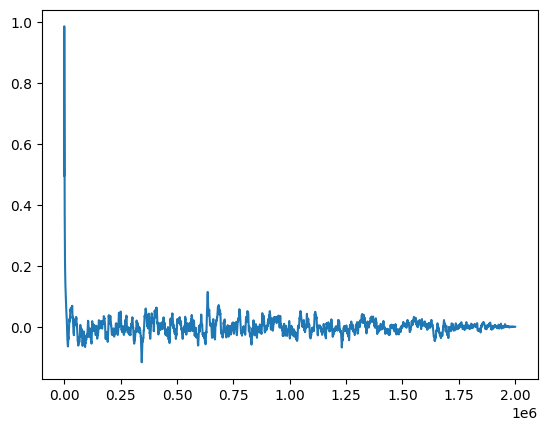

2892


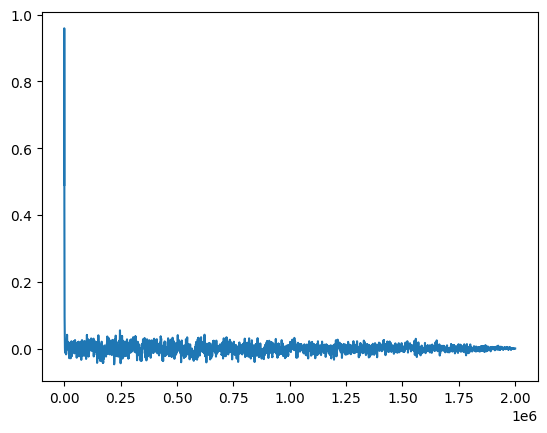

In [159]:
total_samples_plot=2000000
# total_samples_plot = 10000
plt.plot(autocorr_fft_smooth(Channel_dict[0]["I"][:total_samples_plot]))
print(find_coh_time_fft(Channel_dict[0]["I"][:total_samples_plot]))
plt.show()
plt.plot(autocorr_fft_smooth(Channel_dict[1]["I"][:total_samples_plot]))
print(find_coh_time_fft(Channel_dict[1]["I"][:total_samples_plot]))

In [160]:
# multi armed bandit to select next channel to scan
#Right now the dwell time of stuff is around max 20000 samples
dfs_states, dfs_timers, dict_coherence_times = initial_prescan_and_init_coherence(Channel_dict, initial_scan_duration)
print(dict_coherence_times)

#we will create a coherence probability array
total_dwell_sum=0
for channel in dict_coherence_times:
    total_dwell_sum+=1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"])

dwell_probabilities={}
for channel in dict_coherence_times:
    dwell_probabilities[channel]=(1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"]))/total_dwell_sum

# check_sum=0
# for channel in dwell_probabilities:
#     check_sum+=dwell_probabilities[channel]

# print(check_sum)
print(dwell_probabilities)

#Using min dwell time as 0.5sec
min_dwell_samples=int(0.5/sample_time)

print("Min dwell samples is",min_dwell_samples)
prob_1_dwell_samples=min_dwell_samples/min(dwell_probabilities.values())
print(prob_1_dwell_samples)

{0: 'AVAILABLE', 1: 'AVAILABLE'}
{0: {'I': 3465, 'Q': 1481}, 1: {'I': 2423, 'Q': 1377}}
{0: 0.48180545836249133, 1: 0.5181945416375088}
Min dwell samples is 10000
20755.265068990557


In [161]:
# each channel is one arm
num_channels = 2 # number of arms

arm_coherent_time = {}

arm_dwell_time = {}
for channel in dwell_probabilities:
    arm_dwell_time[channel]=int(dwell_probabilities[channel]*prob_1_dwell_samples)    

arms_with_reward = {}
arm_last_played_time = {}
arm_coherent_time = {}

#We want dwell time min to be about 0.5sec

for i in range(num_channels):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_coherent_time[i] = min(dict_coherence_times[i]['I'], dict_coherence_times[i]['Q'])
    #arm_coherent_time[i] = random.randint(400, 1000)
    #arm_dwell_time[i] = int(1e7 / arm_coherent_time[i]) # seems correct

print("initialised dwell times", arm_dwell_time)

initialised dwell times {0: 10000, 1: 10755}


In [162]:
def get_reward(channel_chosen, current_sample_index, arm_last_played_time, arm_coherent_time):
    reward = (current_sample_index - arm_last_played_time[channel_chosen])/arm_coherent_time[channel_chosen]
    return (reward)

In [163]:
def selected_arm(epsilon, available):
    k = random.random()
    if (k < epsilon) :
        next_arm = random.choice(available)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

In [164]:
Wifi_output_samples={}
temp_output_samples = {}
for channel in Channel_dict:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  # storing in the form of a list of elements (sample_num,value) for I and Q
epsilon = 0.2
alpha=0.95
# epsilon_decay = 0.995
total_samples = N
print(total_samples)

current_sample_index = 0
last_update_index = 0
while(current_sample_index<total_samples):
    elapsed = current_sample_index - last_update_index
    print(current_sample_index > 100000 and current_sample_index < 108000)

    update_dfs_states(dfs_states, dfs_timers, elapsed)
    rescan_channels(dfs_states, dfs_timers, Channel_dict, current_sample_index, initial_scan_duration)
    last_update_index = current_sample_index
    available = available_channels(dfs_states)
    print(dfs_states)

    if not available:
        current_sample_index += 100 #just waiting some time till something gets available
        continue

    temp_output_samples = {}

    for i in (available):
        arms_with_reward[i] = get_reward(i, current_sample_index, arm_last_played_time, arm_coherent_time)

    next_arm = selected_arm(epsilon, available)

    # Simulate radar detection mid-operation
    radar_present = (current_sample_index > 100000 and current_sample_index < 108000)
    #if dfs_check_radar(Channel_dict[next_arm]["I"][current_sample_index:current_sample_index + arm_dwell_time[next_arm]]):
    if (radar_present):
        print("before increment", current_sample_index)
        dfs_states[next_arm] = "NOP"
        dfs_timers[next_arm] = 0
        print(f"[DFS] Radar detected on channel {next_arm} during dwell → NOP")
        current_sample_index += arm_dwell_time[next_arm]
        print("testing increment", current_sample_index)
        #print(dfs_states)
        continue

    temp_output_samples[next_arm] = {}
    temp_output_samples[next_arm]['I'] = []
    temp_output_samples[next_arm]['Q'] = []
    arms_with_reward[next_arm] = 0

    #print(available)

    for i in range(arm_dwell_time[next_arm]):
        if current_sample_index==total_samples-1:
            current_sample_index+=1
            break
        Wifi_output_samples[next_arm]['I'].append([current_sample_index, Channel_dict[next_arm]['I'][current_sample_index]])
        Wifi_output_samples[next_arm]['Q'].append([current_sample_index, Channel_dict[next_arm]['Q'][current_sample_index]])
        temp_output_samples[next_arm]['I'].append(Channel_dict[next_arm]['I'][current_sample_index])
        temp_output_samples[next_arm]['Q'].append(Channel_dict[next_arm]['Q'][current_sample_index])
        current_sample_index+=1

    # print(temp_output_samples)
    _, _, coh_time_to_update = initial_prescan_and_init_coherence(temp_output_samples, arm_dwell_time[next_arm])
    arm_coherent_time[next_arm] = alpha*arm_coherent_time[next_arm]+(1-alpha)*min(coh_time_to_update[next_arm]['I'], coh_time_to_update[next_arm]['Q'])
    arm_dwell_time[next_arm] = int(((1/ arm_coherent_time[next_arm])/total_dwell_sum)*prob_1_dwell_samples) # seems correct
    print(arm_dwell_time)
    arm_last_played_time[next_arm] = current_sample_index

2000000
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 9885, 1: 10755}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{1: 'AVAILABLE'}
{0: 9885, 1: 11163}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 10048, 1: 11163}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{1: 'AVAILABLE'}
{0: 10048, 1: 11402}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 9880, 1: 11402}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{1: 'AVAILABLE'}
{0: 9880, 1: 11377}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 9776, 1: 11377}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 9597, 1: 11377}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{1: 'AVAILABLE'}
{0: 9597, 1: 11571}
False
{0: 'AVAILABLE', 1: 'AVAILABLE'}
{0: 'AVAILABLE'}
{0: 9655, 1: 11571}
True
{0: 'AVAILABLE', 1: 'AVAILABLE'}
before increment 103883
[DFS] Radar detected on channel 1 during dwell → NOP
testing increment 115454
False
nop channel 1: timer += 11571 -> 11571 (needs 200000)
{0: 'AVAILABLE', 1: 'NOP'}
{0:

In [165]:
#print(arm_stddev)
#print(arm_mean_time)
# for i in range(num_channels):
#     print(Wifi_output_samples[i]['I'][:100])

print(arm_dwell_time)

{0: 9493, 1: 14678}


In [166]:
def get_sampled_channel(data,total_num_samples):
    "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(total_num_samples)]),'Q':np.array([0 for i in range(total_num_samples)])}
        I = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored
        Q = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples

output_samples_for_each_channel=get_sampled_channel(Wifi_output_samples,N)



In [250]:
# #plt.plot(output_samples_for_each_channel[1]['I'])
# index=2
# plt.plot(output_samples_for_each_channel[2]['I'])
# plt.show()
# plt.plot(Channel_dict[2]["I"])
# #print(len())

Doing Naive method

In [167]:
Wifi_naive_symbols={}
size_of_naive_samples_per_channel=min_dwell_samples

cur_num=0
for channel in Channel_dict:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Channel_dict:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Channel_dict[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Channel_dict[channel]['Q'][cur_num]))
            cur_num+=1
        #cur_num+=size_of_naive_samples_per_channel
        if cur_num>=total_samples:
            break
#I = np.zeros(2_000_000, dtype=np.float64)  # force float64
print(Wifi_naive_symbols[1]['I'][:100])
#Wifi_naive_symbols[channel]['I'] = I  # ensure the mutated array is stored


[(10000, -0.5012838800722912), (10001, -0.4162454077274065), (10002, -0.4297095085222967), (10003, -0.466904143444144), (10004, -0.42279178174025306), (10005, -0.4332456621903198), (10006, -0.39327702082874527), (10007, -0.4265964950518263), (10008, -0.4242088629193801), (10009, -0.409162049197846), (10010, -0.3946828642097154), (10011, -0.37963065069069973), (10012, -0.37012491751790316), (10013, -0.36001302427362036), (10014, -0.3703623871337317), (10015, -0.39752749624450573), (10016, -0.3515482596057268), (10017, -0.3277566786372271), (10018, -0.329129846946009), (10019, -0.342838162536347), (10020, -0.3003155607245713), (10021, -0.3142554859374593), (10022, -0.3026308750282832), (10023, -0.29812704164185405), (10024, -0.32050170255924626), (10025, -0.3138295032036663), (10026, -0.2690913746020662), (10027, -0.30521075842923767), (10028, -0.31573432954415487), (10029, -0.35264962149204004), (10030, -0.3613497681965751), (10031, -0.3911966780358886), (10032, -0.3456390065553684), (1

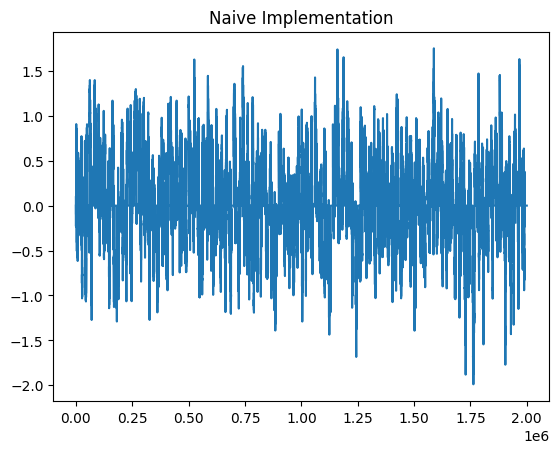

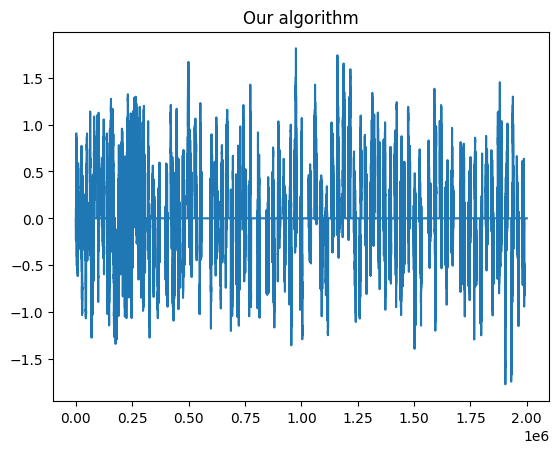

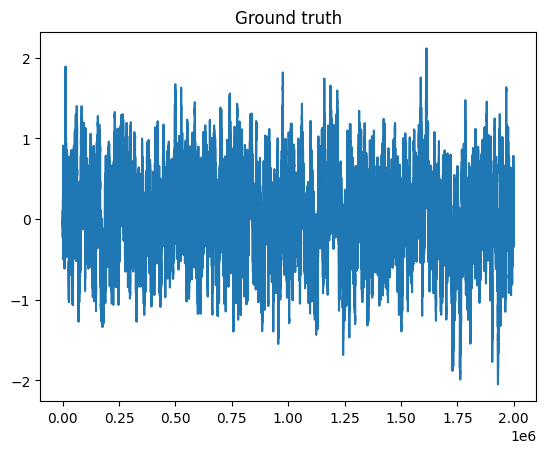

In [168]:
Wifi_output_data_after_interpolation_naive=get_sampled_channel(Wifi_naive_symbols,N)

index=0

plt.title("Naive Implementation")
plt.plot(Wifi_output_data_after_interpolation_naive[index]['I'])
plt.show()
plt.title("Our algorithm")
plt.plot(output_samples_for_each_channel[index]['I'])
plt.show()
plt.title("Ground truth")
plt.plot(Channel_dict[index]["I"])

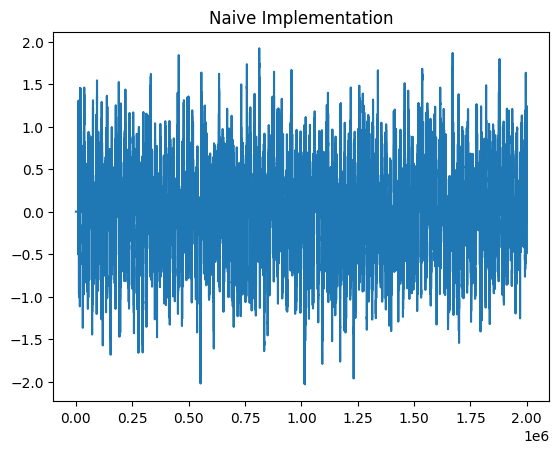

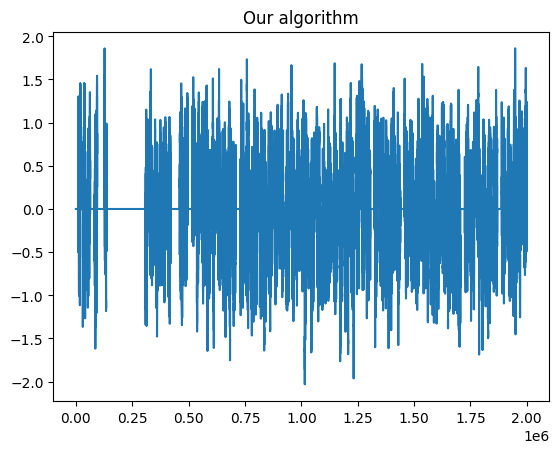

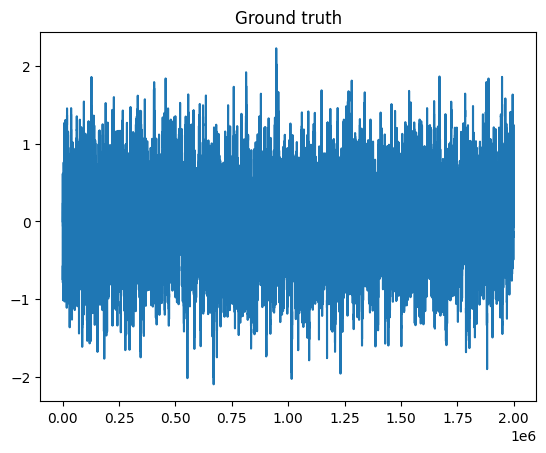

In [169]:
Wifi_output_data_after_interpolation_naive=get_sampled_channel(Wifi_naive_symbols,N)

index=1

plt.title("Naive Implementation")
plt.plot(Wifi_output_data_after_interpolation_naive[index]['I'])
plt.show()
plt.title("Our algorithm")
plt.plot(output_samples_for_each_channel[index]['I'])
plt.show()
plt.title("Ground truth")
plt.plot(Channel_dict[index]["I"])

In [170]:
def finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples):
    """
    Compute per-channel power in fixed-size sample blocks and fill zeros
    between nonzero stretches with the average power of the previous stretch.

    Returns:
        power_per_channel: {
            channel_index: {
                'I': np.ndarray of shape (total_samples,),
                'Q': np.ndarray of shape (total_samples,)
            }
        }
    """
    sampleblock_length = int((0.5 / sample_time) // 10)
    power_per_channel = {}

    for i in range(num_channels):
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])

        power_I = np.zeros(total_samples)
        power_Q = np.zeros(total_samples)

        nonzero_mask = (I_signal != 0) | (Q_signal != 0)
        diff_mask = np.diff(nonzero_mask.astype(int))
        starts = np.where(diff_mask == 1)[0] + 1  # rising edges
        ends = np.where(diff_mask == -1)[0] + 1   # falling edges

        # handle cases where signal starts or ends as nonzero
        if nonzero_mask[0]:
            starts = np.insert(starts, 0, 0)
        if nonzero_mask[-1]:
            ends = np.append(ends, total_samples)

        prev_end = 0
        avg_power_I = 0
        avg_power_Q = 0

        for s, e in zip(starts, ends):
            stretch_len = e - s
            n_blocks = int(np.ceil(stretch_len / sampleblock_length))

            block_powers_I = []
            block_powers_Q = []

            for b in range(n_blocks):
                start_idx = s + b * sampleblock_length
                end_idx = min(s + (b + 1) * sampleblock_length, e)

                I_block = I_signal[start_idx:end_idx]
                Q_block = Q_signal[start_idx:end_idx]

                block_power_I = np.mean(I_block**2)
                block_power_Q = np.mean(Q_block**2)

                power_I[start_idx:end_idx] = block_power_I
                power_Q[start_idx:end_idx] = block_power_Q

                block_powers_I.append(block_power_I)
                block_powers_Q.append(block_power_Q)

            avg_power_I = np.mean(block_powers_I)
            avg_power_Q = np.mean(block_powers_Q)

            # fill zeros before this stretch with average power from current stretch
            if prev_end < s:
                power_I[prev_end:s] = avg_power_I
                power_Q[prev_end:s] = avg_power_Q

            prev_end = e

        # fill tail after last stretch
        if prev_end < total_samples:
            power_I[prev_end:] = avg_power_I
            power_Q[prev_end:] = avg_power_Q

        power_per_channel[i] = {'I': power_I, 'Q': power_Q}

    return power_per_channel

In [171]:
#sample_time = 1/(2*1e4)

result = finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples)

print("Channel 0 Power (first 20 samples):")
print(result[0]['I'][:20])

result_naive = finding_power(Wifi_output_data_after_interpolation_naive, sample_time, num_channels, total_samples)

print("Channel 0 Power (first 20 samples):")
print(result_naive[0]['I'][:20])

result_ground_truth = finding_power(Channel_dict, sample_time, num_channels, total_samples)


Channel 0 Power (first 20 samples):
[0.11271631 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094
 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094
 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094
 0.01486094 0.01486094]
Channel 0 Power (first 20 samples):
[0.11271631 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094
 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094
 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094 0.01486094
 0.01486094 0.01486094]


In [152]:
def plot_power_and_signals(output_samples_for_each_channel, power_per_channel, num_channels_1):
    """
    Plot I/Q signals and their computed power for each channel.
    """
    fig, axs = plt.subplots(num_channels_1, 2, figsize=(12, 6), sharex=True)

    for i in range(num_channels_1):
        # Extract data
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])
        power_I = power_per_channel[i]['I']
        power_Q = power_per_channel[i]['Q']
        samples = np.arange(len(I_signal))

        # --- I component ---
        axs[i, 0].plot(samples, I_signal, label="I signal", color='steelblue', alpha=0.7)
        axs[i, 0].plot(samples, power_I, label="I power", color='crimson', linestyle='--', linewidth=2)
        axs[i, 0].set_title(f"Channel {i} - I Component")
        axs[i, 0].set_ylabel("Amplitude / Power")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.4)

        # --- Q component ---
        axs[i, 1].plot(samples, Q_signal, label="Q signal", color='darkgreen', alpha=0.7)
        axs[i, 1].plot(samples, power_Q, label="Q power", color='orange', linestyle='--', linewidth=2)
        axs[i, 1].set_title(f"Channel {i} - Q Component")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.4)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Original Signals and Computed Power per Channel", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

C:\Users\medha\AppData\Local\Temp\ipykernel_11748\3629842356.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\medha\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


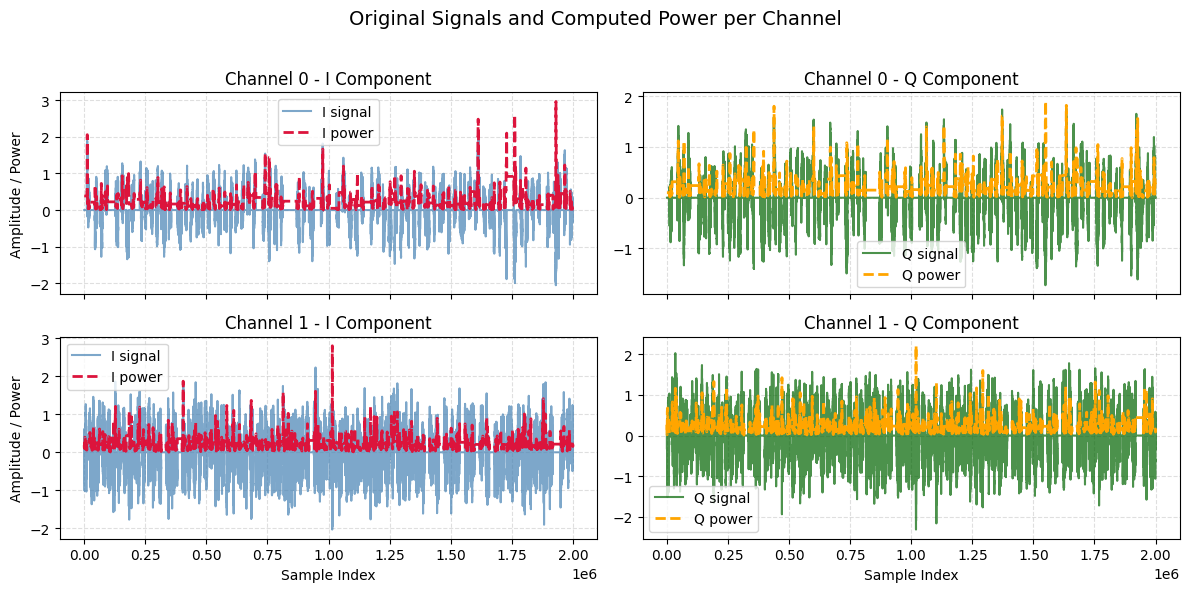

In [153]:
# plot_power_and_signals(output_samples_for_each_channel, result, num_channels)
plot_power_and_signals(output_samples_for_each_channel, result, 2)

C:\Users\medha\AppData\Local\Temp\ipykernel_8168\3629842356.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


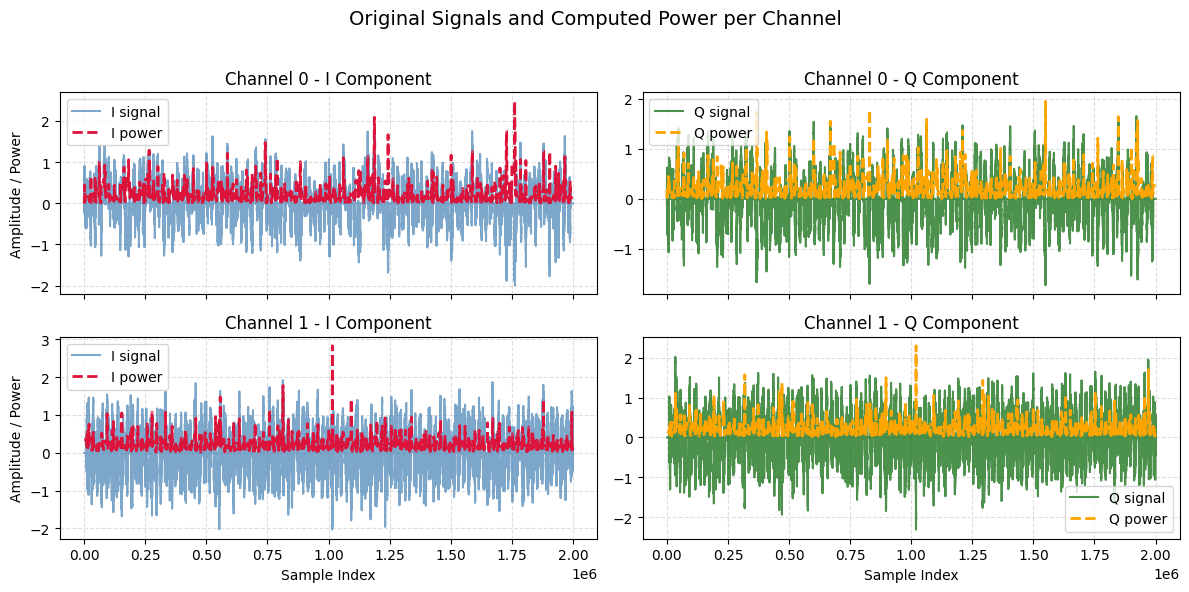

In [106]:
plot_power_and_signals(Wifi_output_data_after_interpolation_naive, result_naive, 2)

C:\Users\medha\AppData\Local\Temp\ipykernel_8168\3629842356.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


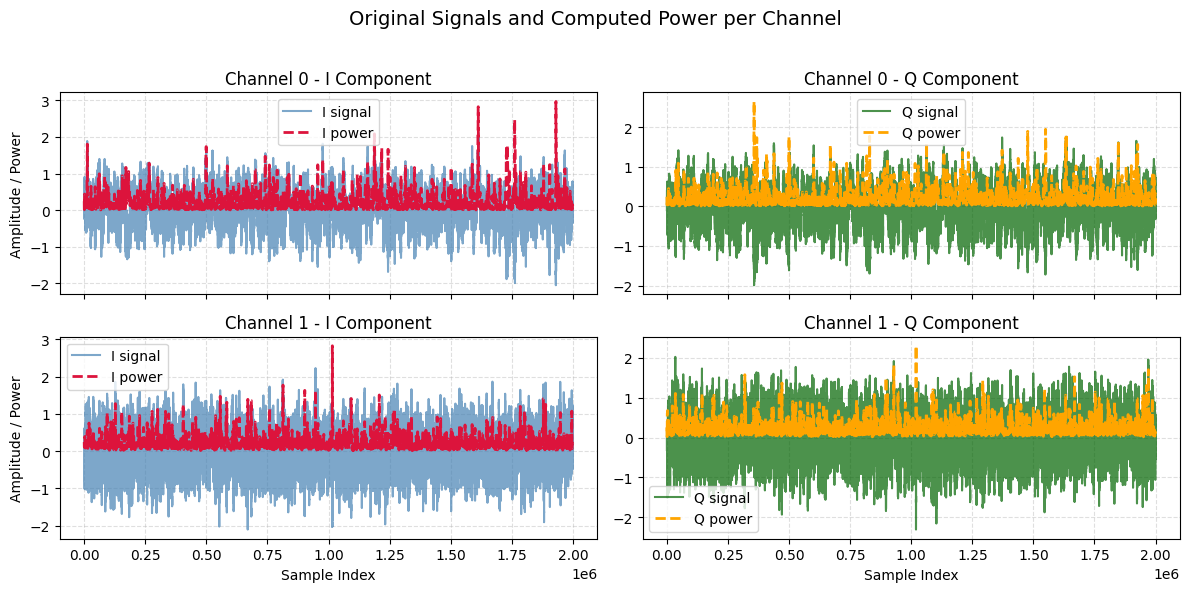

In [107]:
plot_power_and_signals(Channel_dict, result_ground_truth, 2)

In [172]:
def compute_power_differences(result, result_naive, result_ground_truth):
    """
    Compute elementwise differences of power arrays for each channel and component (I, Q)
    between result/result_naive and the ground truth.
    """
    diff_result = {}
    diff_naive = {}

    for ch in result.keys():
        diff_result[ch] = {
            'I': np.abs(result[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result[ch]['Q'] - result_ground_truth[ch]['Q'])
        }
        diff_naive[ch] = {
            'I': np.abs(result_naive[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result_naive[ch]['Q'] - result_ground_truth[ch]['Q'])
        }

    return diff_result, diff_naive


def plot_power_error_per_channel(diff_result, diff_naive, num_channels_to_plot):
    """
    Plot per-channel power errors (I and Q separately).
    Each channel gets two plots: I-error and Q-error.
    """
    fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(12, 3 * num_channels_to_plot), sharex=True)

    # Handle case where only one channel is plotted (so axs is 1D)
    if num_channels_to_plot == 1:
        axs = np.array([axs])

    for i in range(num_channels_to_plot):
    #for i in [7, 8, 9]: 
        samples = np.arange(len(diff_result[i]['I']))

        # ---- I component ----
        axs[i, 0].plot(samples, diff_result[i]['I'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 0].plot(samples, diff_naive[i]['I'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 0].set_title(f"Channel {i} - I Component Error")
        axs[i, 0].set_ylabel("Abs Power Difference")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.5)

        # ---- Q component ----
        axs[i, 1].plot(samples, diff_result[i]['Q'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 1].plot(samples, diff_naive[i]['Q'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 1].set_title(f"Channel {i} - Q Component Error")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.5)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Error vs Ground Truth for Result and Naive Methods", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Compute differences
diff_result, diff_naive = compute_power_differences(result, result_naive, result_ground_truth)

# Plot first 3 channels (or however many you want)
#plot_power_error_per_channel(diff_result, diff_naive, num_channels_to_plot=10)

In [173]:
import pandas as pd

def compute_average_power_difference(diff_result, diff_naive):
    """
    Compute average absolute power difference (scalar) for each channel and component (I, Q)
    from the already-computed difference dictionaries.

    Returns a pandas DataFrame for easy display and further analysis.
    """
    data = []

    for ch in diff_result.keys():
        avg_result_I = np.mean(diff_result[ch]['I'])
        avg_result_Q = np.mean(diff_result[ch]['Q'])
        avg_naive_I = np.mean(diff_naive[ch]['I'])
        avg_naive_Q = np.mean(diff_naive[ch]['Q'])

        data.append({
            'Channel': ch,
            'Avg |I_diff| (Result vs GT)': avg_result_I,
            'Avg |Q_diff| (Result vs GT)': avg_result_Q,
            'Avg |I_diff| (Naive vs GT)': avg_naive_I,
            'Avg |Q_diff| (Naive vs GT)': avg_naive_Q
        })

    df = pd.DataFrame(data)
    return df

avg_diff_df = compute_average_power_difference(diff_result, diff_naive)

print("Average Absolute Power Difference per Channel:")
print(avg_diff_df)

Average Absolute Power Difference per Channel:
   Channel  Avg |I_diff| (Result vs GT)  Avg |Q_diff| (Result vs GT)  \
0        0                     0.152592                     0.154570   
1        1                     0.118072                     0.130545   

   Avg |I_diff| (Naive vs GT)  Avg |Q_diff| (Naive vs GT)  
0                    0.111924                    0.105772  
1                    0.081683                    0.086706  
